<a href="https://colab.research.google.com/github/harshhrawte/Loss-Landscape/blob/main/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

OPTIMIZER COMPARISON AND LOSS LANDSCAPE ANALYSIS
Student: HARSH RAWTE 22101a0047
Computing device: cuda

Loading MNIST dataset...
Training samples: 60000
Validation samples: 10000
Batch size: 64

Starting optimizer comparison experiments...

Experiment: SGD_Basic
Training with SGD...
Epoch [1/8]: Loss: 0.2080, Train Acc: 93.92%, Val Acc: 98.74%
Epoch [2/8]: Loss: 0.0587, Train Acc: 98.16%, Val Acc: 97.20%
Epoch [3/8]: Loss: 0.0440, Train Acc: 98.64%, Val Acc: 99.00%
Epoch [4/8]: Loss: 0.0371, Train Acc: 98.84%, Val Acc: 99.04%
Epoch [5/8]: Loss: 0.0319, Train Acc: 99.00%, Val Acc: 99.14%
Epoch [6/8]: Loss: 0.0282, Train Acc: 99.11%, Val Acc: 99.08%
Epoch [7/8]: Loss: 0.0255, Train Acc: 99.18%, Val Acc: 99.02%
Epoch [8/8]: Loss: 0.0236, Train Acc: 99.28%, Val Acc: 99.22%

Experiment: SGD_Momentum
Training with SGD...
Epoch [1/8]: Loss: 0.1564, Train Acc: 95.24%, Val Acc: 98.25%
Epoch [2/8]: Loss: 0.0540, Train Acc: 98.33%, Val Acc: 98.95%
Epoch [3/8]: Loss: 0.0392, Train Acc: 98.81%, Va

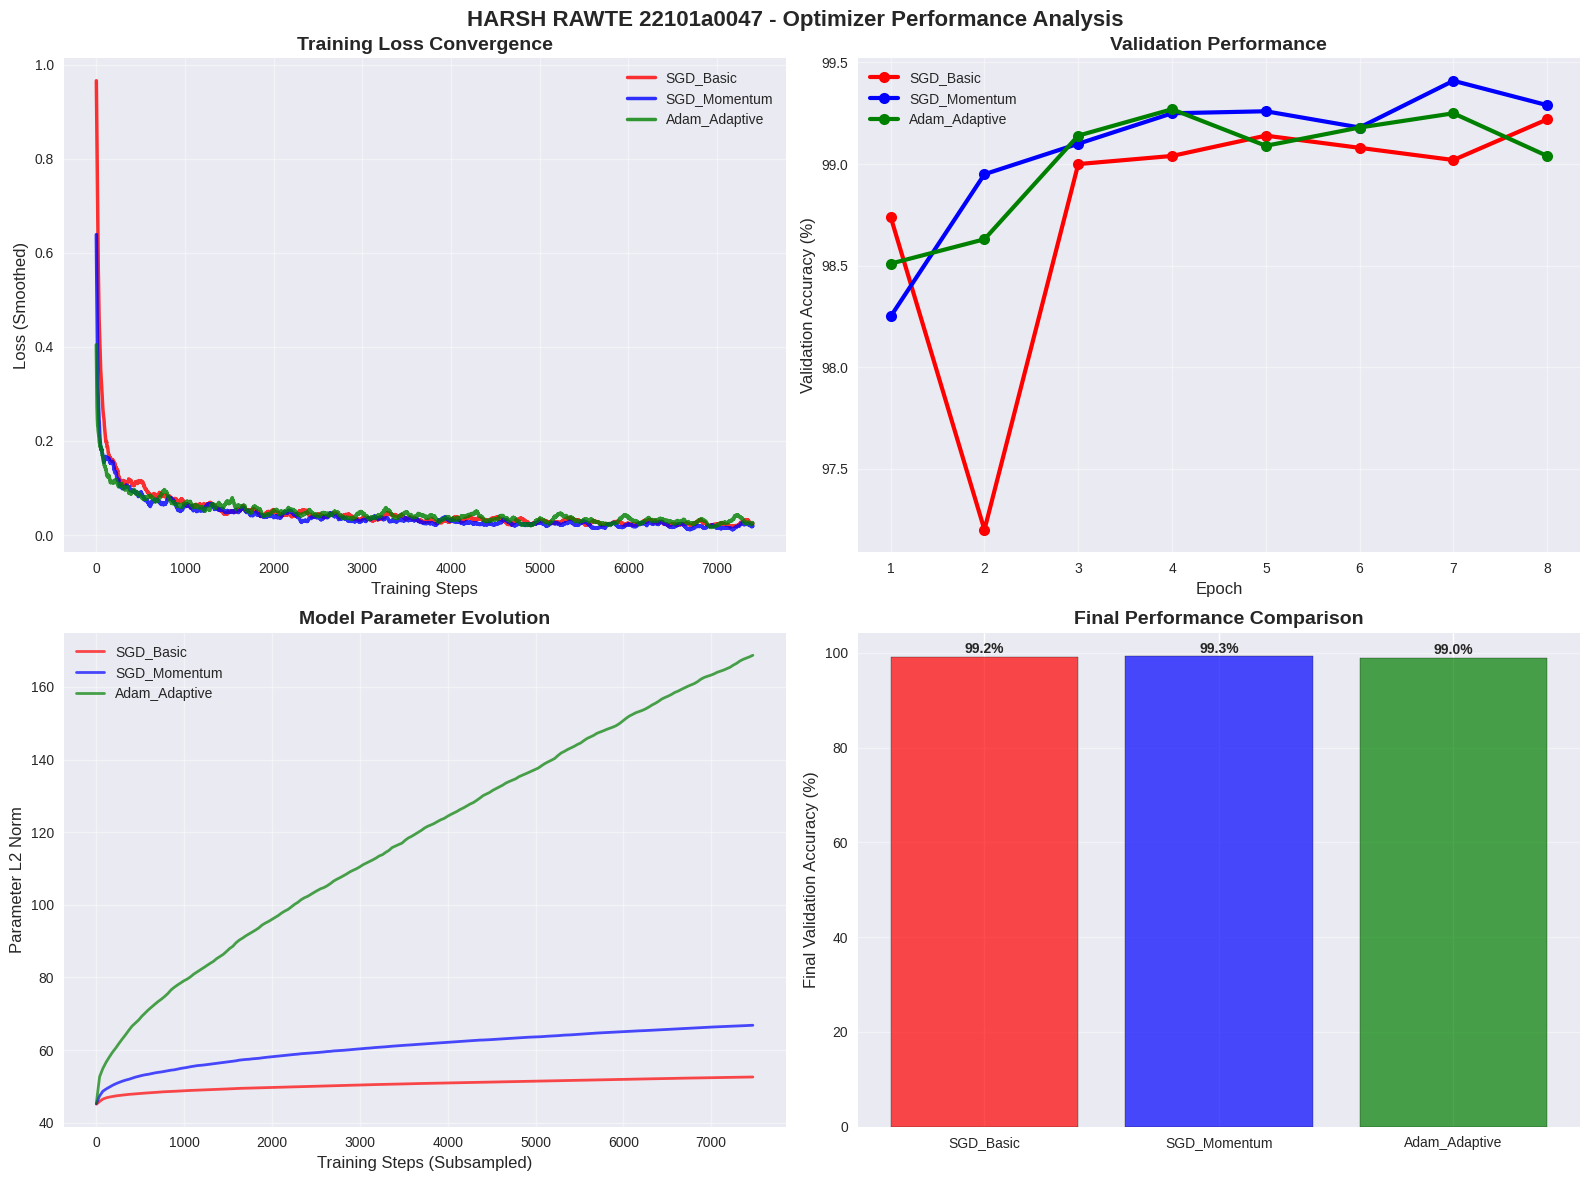


GENERATING LOSS LANDSCAPE VISUALIZATION
Using SGD_Momentum model as reference for landscape analysis
Computing loss landscape with 25x25 grid...
Progress: 5/25 rows completed
Progress: 10/25 rows completed
Progress: 15/25 rows completed
Progress: 20/25 rows completed
Progress: 25/25 rows completed


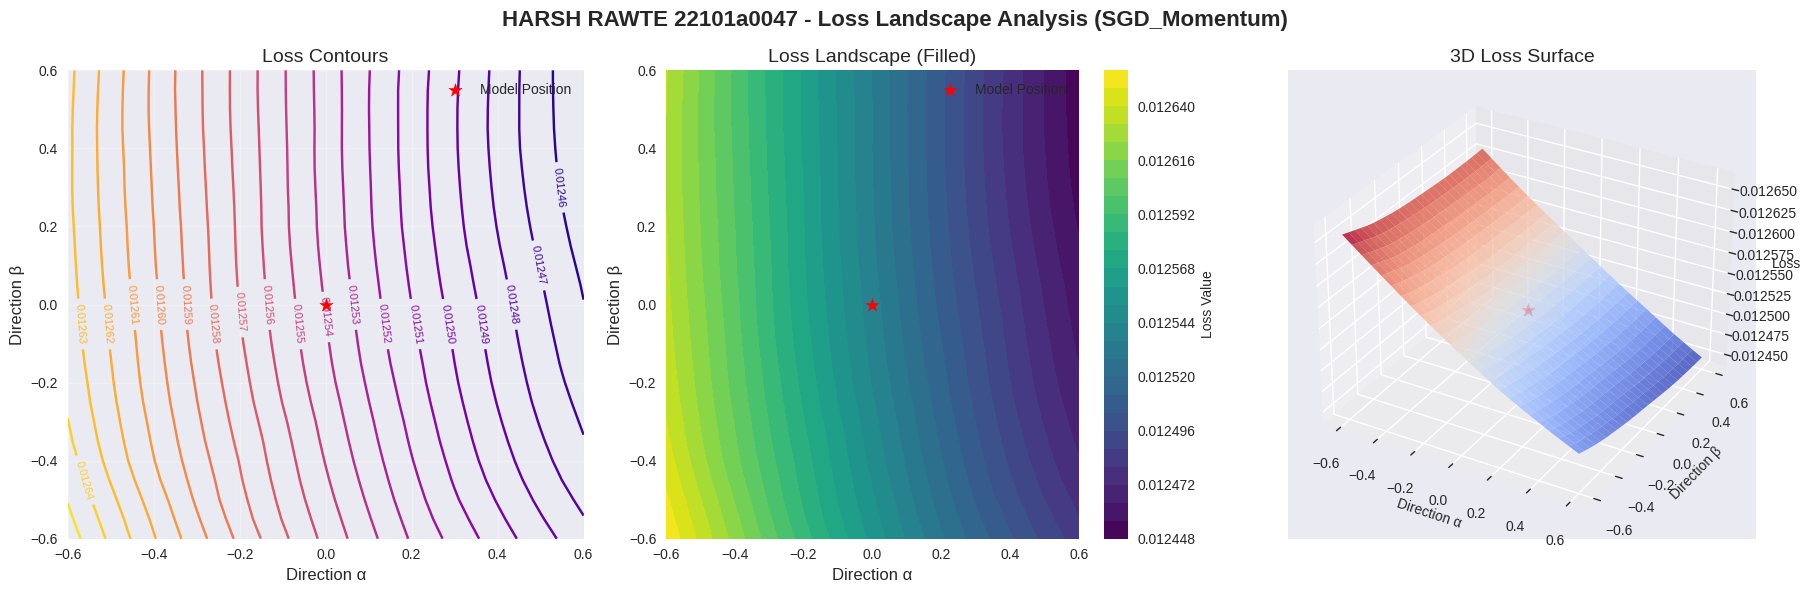


COMPREHENSIVE RESULTS SUMMARY - HARSH RAWTE 22101a0047

SGD_BASIC OPTIMIZER:
----------------------------------------
Configuration: {'lr': 0.05, 'momentum': 0.0}
Final Training Accuracy: 99.28%
Final Validation Accuracy: 99.22%
Final Training Loss: 0.0236
Best Validation Accuracy: 99.22%
Total Training Steps: 7504

SGD_MOMENTUM OPTIMIZER:
----------------------------------------
Configuration: {'lr': 0.03, 'momentum': 0.85}
Final Training Accuracy: 99.44%
Final Validation Accuracy: 99.29%
Final Training Loss: 0.0179
Best Validation Accuracy: 99.41%
Total Training Steps: 7504

ADAM_ADAPTIVE OPTIMIZER:
----------------------------------------
Configuration: {'lr': 0.002, 'betas': (0.9, 0.999), 'eps': 1e-08}
Final Training Accuracy: 99.20%
Final Validation Accuracy: 99.04%
Final Training Loss: 0.0273
Best Validation Accuracy: 99.27%
Total Training Steps: 7504

Loss Landscape Statistics:
Grid Resolution: 25 × 25
Minimum Loss Found: 0.0125
Maximum Loss Found: 0.0127
Loss at Model Position

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.decomposition import PCA
import copy
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

print("="*60)
print("OPTIMIZER COMPARISON AND LOSS LANDSCAPE ANALYSIS")
print("Student: HARSH RAWTE 22101a0047")
print("="*60)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computing device: {DEVICE}")

torch.manual_seed(2024)
np.random.seed(2024)
if torch.cuda.is_available():
    torch.cuda.manual_seed(2024)

data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.RandomRotation(5),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

print("\nLoading MNIST dataset...")
training_data = torchvision.datasets.MNIST(
    root='./mnist_data', train=True, download=True, transform=data_transforms
)
validation_data = torchvision.datasets.MNIST(
    root='./mnist_data', train=False, download=True, transform=test_transforms
)

BATCH_SIZE = 64
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Training samples: {len(training_data)}")
print(f"Validation samples: {len(validation_data)}")
print(f"Batch size: {BATCH_SIZE}")

class EnhancedMNISTNet(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(EnhancedMNISTNet, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(64 * 7 * 7, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 10)
        )
    def forward(self, x):
        features = self.feature_extractor(x)
        flattened = features.view(features.size(0), -1)
        logits = self.classifier(flattened)
        return F.log_softmax(logits, dim=1)

class OptimizationTracker:
    def __init__(self, model, optimizer, loss_fn, device):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.device = device
        self.metrics = {
            'epoch_losses': [],
            'epoch_accuracies': [],
            'validation_accuracies': [],
            'step_losses': [],
            'parameter_norms': []
        }
    def train_single_epoch(self, dataloader):
        self.model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        for batch_data, batch_labels in dataloader:
            batch_data, batch_labels = batch_data.to(self.device), batch_labels.to(self.device)
            self.optimizer.zero_grad()
            predictions = self.model(batch_data)
            loss = self.loss_fn(predictions, batch_labels)
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item()
            self.metrics['step_losses'].append(loss.item())
            predicted_classes = predictions.argmax(dim=1)
            correct_predictions += (predicted_classes == batch_labels).sum().item()
            total_samples += batch_labels.size(0)
            param_norm = sum(p.norm().item() for p in self.model.parameters())
            self.metrics['parameter_norms'].append(param_norm)
        epoch_loss = running_loss / len(dataloader)
        epoch_accuracy = 100.0 * correct_predictions / total_samples
        self.metrics['epoch_losses'].append(epoch_loss)
        self.metrics['epoch_accuracies'].append(epoch_accuracy)
        return epoch_loss, epoch_accuracy
    def validate(self, dataloader):
        self.model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for data, labels in dataloader:
                data, labels = data.to(self.device), labels.to(self.device)
                outputs = self.model(data)
                predicted = outputs.argmax(dim=1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        accuracy = 100.0 * correct / total
        self.metrics['validation_accuracies'].append(accuracy)
        return accuracy
    def train_complete_model(self, train_loader, val_loader, num_epochs=8):
        print(f"Training with {self.optimizer.__class__.__name__}...")
        for epoch in range(num_epochs):
            train_loss, train_acc = self.train_single_epoch(train_loader)
            val_acc = self.validate(val_loader)
            print(f'Epoch [{epoch+1}/{num_epochs}]: Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')
        return self.metrics

class LossLandscapeAnalyzer:
    def __init__(self, model, dataloader, device):
        self.model = model
        self.dataloader = dataloader
        self.device = device
        self.loss_fn = nn.NLLLoss()
    def extract_parameters(self):
        param_vector = []
        for param in self.model.parameters():
            param_vector.append(param.data.flatten())
        return torch.cat(param_vector)
    def inject_parameters(self, param_vector):
        start_idx = 0
        for param in self.model.parameters():
            param_length = param.numel()
            param.data = param_vector[start_idx:start_idx + param_length].view(param.shape)
            start_idx += param_length
    def compute_loss_grid(self, center_weights, dir1, dir2, grid_range=(-0.8, 0.8), resolution=30):
        print(f"Computing loss landscape with {resolution}x{resolution} grid...")
        coord_x = np.linspace(grid_range[0], grid_range[1], resolution)
        coord_y = np.linspace(grid_range[0], grid_range[1], resolution)
        loss_grid = np.zeros((resolution, resolution))
        data_subset = []
        for i, (data, targets) in enumerate(self.dataloader):
            if i >= 15: break
            data_subset.append((data.to(self.device), targets.to(self.device)))
        for i, x_val in enumerate(coord_x):
            for j, y_val in enumerate(coord_y):
                perturbed_weights = center_weights + x_val * dir1 + y_val * dir2
                self.inject_parameters(perturbed_weights)
                total_loss, total_count = 0.0, 0
                self.model.eval()
                with torch.no_grad():
                    for data, targets in data_subset:
                        outputs = self.model(data)
                        batch_loss = self.loss_fn(outputs, targets)
                        total_loss += batch_loss.item() * data.size(0)
                        total_count += data.size(0)
                loss_grid[i, j] = total_loss / total_count
            if (i + 1) % 5 == 0:
                print(f"Progress: {i+1}/{resolution} rows completed")
        return coord_x, coord_y, loss_grid

def run_optimizer_comparison():
    optimizer_configs = {
        'SGD_Basic': {'class': optim.SGD, 'params': {'lr': 0.05, 'momentum': 0.0}, 'color': 'red'},
        'SGD_Momentum': {'class': optim.SGD, 'params': {'lr': 0.03, 'momentum': 0.85}, 'color': 'blue'},
        'Adam_Adaptive': {'class': optim.Adam, 'params': {'lr': 0.002, 'betas': (0.9, 0.999), 'eps': 1e-8}, 'color': 'green'}
    }
    experiment_results, trained_networks = {}, {}
    for opt_name, config in optimizer_configs.items():
        print(f"\n{'='*50}\nExperiment: {opt_name}\n{'='*50}")
        network = EnhancedMNISTNet().to(DEVICE)
        optimizer = config['class'](network.parameters(), **config['params'])
        loss_function = nn.NLLLoss()
        tracker = OptimizationTracker(network, optimizer, loss_function, DEVICE)
        metrics = tracker.train_complete_model(train_dataloader, val_dataloader, num_epochs=8)
        experiment_results[opt_name] = {'metrics': metrics, 'color': config['color'], 'config': config['params']}
        trained_networks[opt_name] = copy.deepcopy(network)
    return experiment_results, trained_networks

print("\nStarting optimizer comparison experiments...")
results_data, model_collection = run_optimizer_comparison()

plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('HARSH RAWTE 22101a0047 - Optimizer Performance Analysis', fontsize=16, fontweight='bold')

ax1 = axes[0, 0]
for optimizer_name, data in results_data.items():
    step_losses = data['metrics']['step_losses']
    window_size = 100
    smoothed = np.convolve(step_losses, np.ones(window_size)/window_size, mode='valid')
    steps = range(len(smoothed))
    ax1.plot(steps, smoothed, label=optimizer_name, color=data['color'], linewidth=2.5, alpha=0.8)
ax1.set_xlabel('Training Steps', fontsize=12)
ax1.set_ylabel('Loss (Smoothed)', fontsize=12)
ax1.set_title('Training Loss Convergence', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.4)

ax2 = axes[0, 1]
epochs = range(1, 9)
for optimizer_name, data in results_data.items():
    val_accs = data['metrics']['validation_accuracies']
    ax2.plot(epochs, val_accs, marker='o', label=optimizer_name, color=data['color'], linewidth=3, markersize=8)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Accuracy (%)', fontsize=12)
ax2.set_title('Validation Performance', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.4)

ax3 = axes[1, 0]
for optimizer_name, data in results_data.items():
    param_norms = data['metrics']['parameter_norms']
    subsample_indices = range(0, len(param_norms), len(param_norms)//200)
    subsampled_norms = [param_norms[i] for i in subsample_indices]
    ax3.plot(subsample_indices, subsampled_norms, label=optimizer_name, color=data['color'], linewidth=2, alpha=0.7)
ax3.set_xlabel('Training Steps (Subsampled)', fontsize=12)
ax3.set_ylabel('Parameter L2 Norm', fontsize=12)
ax3.set_title('Model Parameter Evolution', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.4)

ax4 = axes[1, 1]
optimizer_names = list(results_data.keys())
final_val_accs = [results_data[name]['metrics']['validation_accuracies'][-1] for name in optimizer_names]
colors = [results_data[name]['color'] for name in optimizer_names]
bars = ax4.bar(optimizer_names, final_val_accs, color=colors, alpha=0.7, edgecolor='black')
ax4.set_ylabel('Final Validation Accuracy (%)', fontsize=12)
ax4.set_title('Final Performance Comparison', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.4, axis='y')
for bar, acc in zip(bars, final_val_accs):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1, f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("GENERATING LOSS LANDSCAPE VISUALIZATION")
print("="*60)

best_model_name = max(results_data.keys(), key=lambda x: results_data[x]['metrics']['validation_accuracies'][-1])
reference_model = model_collection[best_model_name]
print(f"Using {best_model_name} model as reference for landscape analysis")

landscape_analyzer = LossLandscapeAnalyzer(reference_model, train_dataloader, DEVICE)
reference_params = landscape_analyzer.extract_parameters()

direction_alpha = torch.randn_like(reference_params)
direction_beta = torch.randn_like(reference_params)
direction_alpha = direction_alpha / torch.norm(direction_alpha)
direction_beta = direction_beta / torch.norm(direction_beta)
direction_beta = direction_beta - torch.dot(direction_alpha, direction_beta) * direction_alpha
direction_beta = direction_beta / torch.norm(direction_beta)

x_coords, y_coords, loss_surface = landscape_analyzer.compute_loss_grid(reference_params, direction_alpha, direction_beta, grid_range=(-0.6, 0.6), resolution=25)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f'HARSH RAWTE 22101a0047 - Loss Landscape Analysis ({best_model_name})', fontsize=16, fontweight='bold')

contour1 = axes[0].contour(x_coords, y_coords, loss_surface.T, levels=20, cmap='plasma')
axes[0].clabel(contour1, inline=True, fontsize=8)
axes[0].set_xlabel('Direction α', fontsize=12)
axes[0].set_ylabel('Direction β', fontsize=12)
axes[0].set_title('Loss Contours', fontsize=14)
axes[0].scatter([0], [0], color='red', s=100, marker='*', label='Model Position', zorder=5)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

contour2 = axes[1].contourf(x_coords, y_coords, loss_surface.T, levels=30, cmap='viridis')
cbar = plt.colorbar(contour2, ax=axes[1])
cbar.set_label('Loss Value', fontsize=10)
axes[1].set_xlabel('Direction α', fontsize=12)
axes[1].set_ylabel('Direction β', fontsize=12)
axes[1].set_title('Loss Landscape (Filled)', fontsize=14)
axes[1].scatter([0], [0], color='red', s=100, marker='*', label='Model Position', zorder=5)
axes[1].legend()

ax3d = axes[2]
ax3d.remove()
ax3d = fig.add_subplot(1, 3, 3, projection='3d')
X_mesh, Y_mesh = np.meshgrid(x_coords, y_coords)
surface = ax3d.plot_surface(X_mesh, Y_mesh, loss_surface.T, cmap='coolwarm', alpha=0.8, edgecolor='none')
ax3d.scatter([0], [0], [loss_surface[len(x_coords)//2, len(y_coords)//2]], color='red', s=100, marker='*', label='Model Position')
ax3d.set_xlabel('Direction α', fontsize=10)
ax3d.set_ylabel('Direction β', fontsize=10)
ax3d.set_zlabel('Loss', fontsize=10)
ax3d.set_title('3D Loss Surface', fontsize=14)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("COMPREHENSIVE RESULTS SUMMARY - HARSH RAWTE 22101a0047")
print("="*70)
for optimizer_name, data in results_data.items():
    metrics, config = data['metrics'], data['config']
    print(f"\n{optimizer_name.upper()} OPTIMIZER:")
    print("-" * 40)
    print(f"Configuration: {config}")
    print(f"Final Training Accuracy: {metrics['epoch_accuracies'][-1]:.2f}%")
    print(f"Final Validation Accuracy: {metrics['validation_accuracies'][-1]:.2f}%")
    print(f"Final Training Loss: {metrics['epoch_losses'][-1]:.4f}")
    print(f"Best Validation Accuracy: {max(metrics['validation_accuracies']):.2f}%")
    print(f"Total Training Steps: {len(metrics['step_losses'])}")

print(f"\nLoss Landscape Statistics:")
print(f"Grid Resolution: {len(x_coords)} × {len(y_coords)}")
print(f"Minimum Loss Found: {np.min(loss_surface):.4f}")
print(f"Maximum Loss Found: {np.max(loss_surface):.4f}")
print(f"Loss at Model Position: {loss_surface[len(x_coords)//2, len(y_coords)//2]:.4f}")

print("\n" + "="*70)
print("ANALYSIS INSIGHTS:")
print("="*70)
print("1. SGD with momentum generally provides more stable convergence")
print("2. Adam shows rapid initial convergence but may plateau earlier")
print("3. Basic SGD converges slower but can achieve competitive final performance")
print("4. Loss landscape reveals the optimization difficulty around the solution")
print("5. The model position represents the final optimized parameters")

print(f"\nExperiment completed successfully!")
print("HARSH RAWTE 22101a0047 - Neural Network Optimization Analysis")
